# KBMod Orbit Fitting

This notebook shows how to get orbit elements from results output by a **KBMOD** search.

## Requirements

* Requires cloning [dirac-institute/pyOrbfit](https://github.com/dirac-institute/pyOrbfit) (our branch of David Gerdes' python wrapper for the Bernstein and Khushalani (2000) orbit fitting code.

* Add the location for the `pyOrbfit` directory to the **KBMOD** `setup.bash` file as `$PYORBFIT_HOME`.

* Source the `setup.bash` file and you're good to go!

## Imports

Here we import tools for getting the data we need from the images and relevant data files. The actual code we use for orbit calculating is found in the `ephem_utils` class in the **KBMOD** codebase.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from kbmod_info import KbmodInfo
import pickle
import json
import seaborn as sns
from astropy.table import Table
from pyOrbfit.Orbit import Orbit
from tqdm import tqdm
import re
from astropy.coordinates import SkyCoord, ICRS, solar_system_ephemeris, get_body_barycentric, EarthLocation
import astropy.units as u
from astropy.time import Time

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get relevant data

### Data required

* List of visit numbers and visit times in MJD.

* One of the processed images used in the **KBMOD** search so that we can grab the WCS

* List of visits in the search

* **KBMOD** results file

In [2]:
from create_stamps import CreateStamps

def loadStamps(results_dir,im_dir,suffix):

    image_list = sorted(os.listdir(im_dir))
    image_list = [os.path.join(im_dir, im_name) for im_name in image_list]

    stamper = CreateStamps()
    lc_filename = os.path.join(results_dir, 'lc_%s.txt' % suffix)
    psi_filename = os.path.join(results_dir, 'psi_{}.txt'.format(suffix))
    phi_filename = os.path.join(results_dir, 'phi_{}.txt'.format(suffix))
    lc_index_filename = os.path.join(results_dir, 'lc_index_%s.txt' % suffix)
    stamp_filename = os.path.join(results_dir, 'ps_%s.txt' % suffix)
    result_filename = os.path.join(results_dir, 'results_%s.txt' % suffix)

    result_exists = os.path.isfile(result_filename)
    
    if result_exists:
        lc_list,lc_index = stamper.load_lightcurves(lc_filename,lc_index_filename)
        psi,phi,lc_index = stamper.load_psi_phi(psi_filename, phi_filename, lc_index_filename)
        stamps = stamper.load_stamps(stamp_filename)
        all_stamps=np.load(os.path.join(results_dir, 'all_ps_%s.npy' % suffix))
        results = stamper.load_results(result_filename)
        keep_idx = []
        for lc_num, lc in list(enumerate(lc_list)):
            if len(lc) > 5:
                keep_idx.append(lc_num)
        return(results,all_stamps)
    else:
        warnings.warn('No results found. Returning empty lists')
        return([],[],[],[],[],[],[],[],[])

pg_num = 284
ccd_num=29
image_directory = '/epyc/users/smotherh/good_warps_good_seeing/{:03d}/{:02d}'.format(pg_num, ccd_num)
    # KBMOD results output
results_dir = '/epyc/users/smotherh/xsede_results/{:03d}/{:02d}/'.format(pg_num,ccd_num)
results, all_stamps = loadStamps(results_dir, image_directory, 'XSEDE')

/astro/store/epyc/projects/lsst_comm/stack_w_2020_38/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/astro/store/epyc/projects/lsst_comm/stack_w_2020_38/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/astro/store/epyc/projects/lsst_comm/stack_w_2020_38/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type'

In [109]:
pg_num = 284
ccd_num = 29
index=0
suffix = 'XSEDE'
fo_result = load_findorb_results(pg_num,ccd_num,index)
fo_result['objects']

{'c111112': {'object': 'c111112',
  'packed': 'c111112',
  'created': 2459221.18185,
  'created iso': '2021-01-06T16:21:52Z',
  'elements': {'central body': 'Sun',
   'frame': 'J2000 ecliptic',
   'epoch_iso': '2015-04-22T00:00:00Z',
   'epoch': 2457134.5,
   'P': 48369.99838546418,
   'P sigma': 32488,
   'M': 296.3308086278618,
   'M sigma': 80,
   'n': 0.0074426299776,
   'n sigma': 0.005,
   'a': 25.9807547911705,
   'a sigma': 11.6,
   'e': 0.0584637905553,
   'e sigma': 0.225,
   'q': 24.4618213845912,
   'q sigma': 10.2,
   'Q': 27.4996881977498,
   'Q sigma': 185,
   'i': 5.9608783333802,
   'i sigma': 80,
   'arg_per': 340.7559132130402,
   'arg_per sigma': 100,
   'asc_node': 290.8920776972919,
   'asc_node sigma': 60,
   'Tp': 2465689.16301076,
   'Tp sigma': 8595,
   'Tp_iso': '2038-09-22T15:54:44.129Z',
   'rms_residual': 0.2484,
   'weighted_rms_residual': 0.4967,
   'n_resids': 40,
   'U': 9.3076,
   'p_NEO': 0.0661,
   'MOIDs': {'Mercury': 23.998392,
    'Venus': 23.734

In [20]:
def get_mpc_times(filename):

    """
    Read in a file with observations in MPC format and return the coordinates.

    Inputs
    ------
    filename: str
        The name of the file with the MPC-formatted observations.

    Returns
    -------
    c: astropy SkyCoord object
        A SkyCoord object with the ra, dec of the observations.
    """
    iso_times = []
    time_frac = []
    ra = []
    dec = []

    with open(filename, 'r') as f:
        for line in f:
            year = str(line[15:19])
            month = str(line[20:22])
            day = str(line[23:31])
            iso_times.append(str('%s-%s-%s' % (year,month,day)))
            time_frac.append(str(line[25:31]))
            ra.append(str(line[32:44]))
            dec.append(str(line[44:56]))

    return iso_times

def load_pg_nums(file_path):
    found_object_filenames = os.listdir(file_path)
    pg_nums = []
    ccd_nums = []
    indexes = []
    for file in found_object_filenames:
        if file[-4:] == '.png':
            pg_nums.append(int(file[0:3]))
            ccd_nums.append(int(file[4:6]))
            indexes.append(int(file[-8:-4]))
    return(pg_nums, ccd_nums, indexes)

def load_results(pg_num, ccd_num, suffix='XSEDE'):
    # Arrays of Visit Numbers and Visit Times
    visit_df = pd.read_csv('/epyc/users/smotherh/DECAM_Data_Reduction/loriallen_times.dat', delimiter=' ',
                           skiprows=1, names=['visit_num', 'visit_mjd'])

    with open('/epyc/users/smotherh/LoriAllen/pointing_metadata/PickledPointings.pkl', 'rb') as f:
        Pointing_Groups = pickle.load(f)

    # Image File
    image_directory = '/epyc/users/smotherh/good_warps_good_seeing/{:03d}/{:02d}'

    # List of visits searched
    results_visit_list = [int(visit[0:6]) for visit in os.listdir(image_directory.format(pg_num,ccd_num))]
    image_file = os.path.join(image_directory.format(pg_num,ccd_num), str(results_visit_list[0]) + '.fits')


    # KBMOD results output
    results_file = '/epyc/users/smotherh/xsede_results/{:03d}/{:02d}/results_{}.txt'.format(pg_num,ccd_num,suffix)
    # Take the data and data locations specified above and give them to `ephem_utils`.
    # Also need to specify the observatory code where the data was taken.
    results_array = np.genfromtxt(results_file)
    # Observatory ID
    cerro_tololo_id = '807'

    kbmod_info = KbmodInfo(results_file, image_file,
                     visit_df['visit_num'].values, 
                     visit_df['visit_mjd'].values, 
                     results_visit_list, cerro_tololo_id)
    return(kbmod_info)

def format_results(pg_num, ccd_num, index, suffix='XSEDE'):
    kbmod_info = load_results(pg_num, ccd_num, suffix=suffix)
    
    # Take one of the results from the file and convert the information to (ra, dec) stored in `ep.coords`.
    kbmod_info.get_searched_radec(index)
    
    # Take these coordinates and output them into MPC format.
    # By default this will save it to a file called `kbmod_mpc.dat` but another filename can be specified.
    output_file_name = '{:03d}_{:02d}_{:04d}_mpc.dat'.format(pg_num,ccd_num,index)
    mpc_names = kbmod_info.save_results_mpc(output_file_name)
    return(kbmod_info)

def load_findorb_results(pg_num, ccd_num, index):
    object_string = '{:03d}_{:02d}_{:04d}'.format(pg_num,ccd_num,index)
    with open('/epyc/users/smotherh/kbmod_epyc/notebooks/find_orb_results/{}/total.json'.format(object_string,'r')) as f:
        fo_results = json.load(f)
    return(fo_results)

def parse_findorb_results(pg_nums, ccd_nums, indexes):
    orbit_dict = {}
    orbit_dict_key = '{:03d}_{:02d}_{:04d}'
    a = []
    a_err = []
    e = []
    e_err = []
    i = []
    i_err = []
    lan = []
    lan_err = []
    aop = []
    aop_err = []
    top = []
    top_err = []
    
    for j in range(len(pg_nums)):
        pg_num = pg_nums[j]
        ccd_num = ccd_nums[j]
        index = indexes[j]
        fo_result = load_findorb_results(pg_num,ccd_num,index)
        fo_ele = fo_result['objects']['c111112']['elements']
        a.append(fo_ele['a'])
        e.append(fo_ele['e'])
        i.append(fo_ele['i'])
        lan.append(fo_ele['asc_node'])
        aop.append(fo_ele['arg_per'])
        top.append(fo_ele['Tp'])
        try:
            a_err.append(fo_ele['a sigma'])
            e_err.append(fo_ele['e sigma'])
            i_err.append(fo_ele['i sigma'])
            aop_err.append(fo_ele['arg_per sigma'])
            lan_err.append(fo_ele['asc_node sigma'])
            top_err.append(fo_ele['Tp sigma'])
        except:
            a_err.append(0)
            e_err.append(0)
            i_err.append(0)
            aop_err.append(0)
            lan_err.append(0)
            top_err.append(0)
    return(a, a_err, e, e_err, i, i_err, lan, lan_err, aop, aop_err, top, top_err)

def parse_bernstein_results(pg_nums, ccd_nums, indexes, orbit_dict):
    orbit_dict_key = '{:03d}_{:02d}_{:04d}'
    a = []
    a_err = []
    e = []
    e_err = []
    i = []
    i_err = []
    lan = []
    lan_err = []
    aop = []
    aop_err = []
    top = []
    top_err = []
    for j in range(len(pg_nums)):
        key = orbit_dict_key.format(pg_nums[j], ccd_nums[j], indexes[j])
        values = orbit_dict[key]
        a.append(values[0]['a'])
        a_err.append(values[1]['a'])
        e.append(values[0]['e'])
        e_err.append(values[1]['e'])
        i.append(values[0]['i'])
        i_err.append(values[1]['i'])
        lan.append(values[0]['lan'])
        lan_err.append(values[1]['lan'])
        aop.append(values[0]['aop'])
        aop_err.append(values[1]['aop'])
        top.append(values[0]['top'])
        top_err.append(values[1]['top'])
    return(a, a_err, e, e_err, i, i_err, lan, lan_err, aop, aop_err, top, top_err)

def find_orbits_findorb(pg_num, ccd_num, index, suffix='XSEDE',gen_mpc_files=True):
    os.environ['PATH'] = '~/bin:$PATH'
    if gen_mpc_files:
        ep = format_results(pg_num,ccd_num,index)
    
    object_string = '{:03d}_{:02d}_{:04d}'.format(pg_num,ccd_num,index)
    output_file_name = '{}_mpc.dat'.format(object_string)
    iso_times = get_mpc_times(output_file_name)

    os.system('mkdir find_orb_results/{}'.format(object_string))
    #-tEjd{} tells find_orb to give the state vector at the time in {}
    os.system('fo /epyc/users/smotherh/kbmod_epyc/notebooks/{} -O find_orb_results/{} -tEjd{}'.format(output_file_name,object_string,Time(iso_times[0]).tt.jd))
    fo_results = load_findorb_results(pg_num,ccd_num,index)
    return(fo_results)
    
def find_orbits_bernstein(pg_num, ccd_num, index, suffix='XSEDE', gen_mpc_files=True, return_covar=False):
    if gen_mpc_files:
        kbmod_info = format_results(pg_num, ccd_num, index, suffix=suffix)
    else:
        kbmod_info = load_results(pg_num, ccd_num, suffix=suffix)

    
    # Take in the file with the MPC-formatted observations and 
    # use the wrapped Bernstein and Khushalani code to get the orbital elements.
    # If no file is specified it will look for the default `kbmod_mpc.dat` filename.
    input_file_name = '{:03d}_{:02d}_{:04d}_mpc.dat'.format(pg_num,ccd_num,index)
    
    o = Orbit(file=input_file_name)
    #o = ep.predict_elements(file_in=input_file_name)
    
    el = o.elements
    err = o.elements_errs
    covar = o.covar_aei
    if return_covar:
        return(el, err, covar, o)
    else:
        return(el, err)
    
def get_ber_bary_dist(pg_nums, ccd_nums, indexes, orbit_dict):
    orbit_dict_key = '{:03d}_{:02d}_{:04d}'
    bary_dist = []
    bary_dist_err = []
    for j in range(len(pg_nums)):
        key = orbit_dict_key.format(pg_nums[j], ccd_nums[j], indexes[j])
        values = orbit_dict[key]
        dist, err = values[3].barycentric_distance()
        bary_dist.append(dist)
        bary_dist_err.append(err)
    return(bary_dist, bary_dist_err)

def plot_fo_ber_comparison(fo, ber):
    fo_a, fo_a_err, fo_e, fo_e_err, fo_i, fo_i_err, fo_lan, fo_lan_err, fo_aop, fo_aop_err, fo_top, fo_top_err = fo
    ber_a, ber_a_err, ber_e, ber_e_err, ber_i, ber_i_err, ber_lan, ber_lan_err, ber_aop, ber_aop_err, ber_top, ber_top_err = ber
    x = np.linspace(0,len(ber_a)-1,len(ber_a))
    fig, ax = plt.subplots(nrows=6, ncols=2, figsize=[12,24])
    
    top_min = np.min([ber_top, fo_top])
    top_max = np.max([ber_top, fo_top])
    top_lim = [top_min*0.95, top_max*1.05]

    ax[0][0].errorbar(x,ber_a,yerr=ber_a_err,marker='.',ms=10,ls='',c='tab:red')
    ax[0][0].set_title('Bernstein TNO',fontsize=30)
    ax[0][0].set_ylim([0,75])
    ax[1][0].errorbar(x,ber_e,yerr=ber_e_err,marker='.',ms=10,ls='',c='tab:green')
    ax[1][0].set_ylim([0,.75])
    ax[2][0].errorbar(x,ber_i,yerr=ber_i_err,marker='.',ms=10,ls='',c='tab:blue')
    ax[2][0].set_ylim([-5,180])
    ax[3][0].errorbar(x,ber_lan,yerr=ber_lan_err,marker='.',ms=10,ls='',c='tab:blue')
    ax[3][0].set_ylim([0,360])
    ax[4][0].errorbar(x,ber_aop,yerr=ber_aop_err,marker='.',ms=10,ls='',c='tab:blue')
    ax[4][0].set_ylim([0,360])
    ax[5][0].errorbar(x,ber_top,yerr=ber_top_err,marker='.',ms=10,ls='',c='tab:blue')
    ax[5][0].set_ylim(top_lim)
    ax[0][0].set_ylabel('a',fontsize=24)
    ax[1][0].set_ylabel('e',fontsize=24)
    ax[2][0].set_ylabel('i',fontsize=24)
    ax[3][0].set_ylabel('lan',fontsize=24)
    ax[4][0].set_ylabel('aop',fontsize=24)
    ax[5][0].set_ylabel('top',fontsize=24)


    x = np.linspace(0,len(fo_a)-1,len(fo_a))

    ax[0][1].errorbar(x,fo_a,yerr=fo_a_err,marker='.',ms=10,ls='',c='tab:red')
    ax[0][1].set_title('FindOrb', fontsize=30)
    ax[0][1].set_ylim([0,75])
    ax[1][1].errorbar(x,fo_e,yerr=fo_e_err,marker='.',ms=10,ls='',c='tab:green')
    ax[1][1].set_ylim([0,.75])
    ax[2][1].errorbar(x,fo_i,yerr=fo_i_err,marker='.',ms=10,ls='',c='tab:blue')
    ax[2][1].set_ylim([-5,180])
    ax[3][1].errorbar(x,fo_lan,yerr=fo_lan_err,marker='.',ms=10,ls='',c='tab:blue')
    ax[3][1].set_ylim([0,360])
    ax[4][1].errorbar(x,fo_aop,yerr=fo_aop_err,marker='.',ms=10,ls='',c='tab:blue')
    ax[4][1].set_ylim([0,360])
    ax[5][1].errorbar(x,fo_top,yerr=fo_top_err,marker='.',ms=10,ls='',c='tab:blue')
    ax[5][1].set_ylim(top_lim)
    ax[0][1].set_ylabel('a',fontsize=24)
    ax[1][1].set_ylabel('e',fontsize=24)
    ax[2][1].set_ylabel('i',fontsize=24)
    ax[3][1].set_ylabel('lan',fontsize=24)
    ax[4][1].set_ylabel('aop',fontsize=24)
    ax[5][1].set_ylabel('top',fontsize=24)
    plt.tight_layout()

    
    return(fig, ax)

def get_fo_bary_dist(pg_num, ccd_num, index):
    
    object_string = '{:03d}_{:02d}_{:04d}'.format(pg_num,ccd_num,index)
    output_file_name = '{}_mpc.dat'.format(object_string)
    iso_times = get_mpc_times(output_file_name)
    
    object_string = '{:03d}_{:02d}_{:04d}'.format(pg_num,ccd_num,index)
    state_vector_string = []
    state_vector_start=False
    state_vector_num = 0
    with open('/epyc/users/smotherh/kbmod_epyc/notebooks/find_orb_results/{}/elements.txt'.format(object_string,'r')) as f:
        for line in f:
            if state_vector_start and state_vector_num<2:
                state_vector_string.append(line)
                state_vector_num+=1

            if '# State vector (heliocentric equatorial J2000):' in line:
                state_vector_start=True
    state_vector = []
    for string in state_vector_string:
        state_vector.append(np.array(re.findall(r'[-+]?\d*\.\d+|\d+',string)).astype(float))
    state_vector = np.array(state_vector)

    np.linalg.norm(state_vector[0])
    obj_pos = SkyCoord(state_vector[0][0]*u.au, state_vector[0][1]*u.au, state_vector[0][2]*u.au, representation_type='cartesian')

    with solar_system_ephemeris.set('de432s'): #https://docs.astropy.org/en/stable/coordinates/solarsystem.html
        solar_pos = get_body_barycentric('sun', Time(iso_times[0]))
        
    bary_pos = [obj_pos.x + solar_pos.x, obj_pos.y + solar_pos.y, obj_pos.z + solar_pos.z]
    bary_dist = np.linalg.norm([bary_pos[0].value, bary_pos[1].value, bary_pos[2].value])
    return(bary_dist)

def load_horizon_orbits(known_kbmod_filepath, data_type = 'orbital_elements'):
    a = []
    e = []
    i = []
    lan = []
    aop = []
    top = []
    bary_dist = []
    pg_nums, ccd_nums, indexes = load_pg_nums(known_kbmod_filepath)
    for j in range(len(pg_nums)):
        pg_num = pg_nums[j]
        ccd_num = ccd_nums[j]
        orbit_table = Table.read('/epyc/users/smotherh/kbmod_epyc/notebooks/Known_object_orbits.csv')
        idx = np.logical_and(orbit_table['pg']==pg_num, orbit_table['ccd']==ccd_num)
        a.append(orbit_table[idx]['a'].data)
        e.append(orbit_table[idx]['e'].data)
        i.append(orbit_table[idx]['incl'].data)
        lan.append(orbit_table[idx]['Omega'].data)
        aop.append(orbit_table[idx]['w'].data)
        top.append(orbit_table[idx]['Tp_jd'].data)
        bary_dist.append(orbit_table[idx]['init_bary_dist'].data)
    if data_type == 'orbital_elements':
        return(a,e,i,lan,aop,top)
    elif data_type == 'bary_dist':
        return(bary_dist)

In [8]:
pg_nums, ccd_nums, indexes = load_pg_nums('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/known_objects/kbmod_stamps')
i=2
el, err, covar, o = find_orbits_bernstein(pg_nums[i],ccd_nums[i],indexes[i],gen_mpc_files=False, return_covar=True)

In [8]:
print('X: {} +/- {}'.format(o.orbit_xyz.x,np.diag(o.covar_xyz)[0]))
print('Y: {} +/- {}'.format(o.orbit_xyz.y,np.diag(o.covar_xyz)[1]))
print('Z: {} +/- {}'.format(o.orbit_xyz.z,np.diag(o.covar_xyz)[2]))
print('VX: {} +/- {}'.format(o.orbit_xyz.xdot,np.diag(o.covar_xyz)[3]))
print('VY: {} +/- {}'.format(o.orbit_xyz.ydot,np.diag(o.covar_xyz)[4]))
print('VZ: {} +/- {}'.format(o.orbit_xyz.zdot,np.diag(o.covar_xyz)[5]))


X: -32.33466246709738 +/- 3.4543775293185917
Y: -23.14952562503331 +/- 1.778928742104804
Z: 0.026449287621265187 +/- 2.4554214554197423e-06
VX: 0.5871628609584455 +/- 0.2564914753708058
VY: -0.8181395453520417 +/- 0.17839369454212817
VZ: -0.06327697576195866 +/- 3.1456991042250826e-05


In [96]:
x = o.orbit_xyz.x
y = o.orbit_xyz.y
z = o.orbit_xyz.z
print(np.linalg.norm([o.xBary, o.yBary, o.zBary]))
print(np.sqrt(x**2+y**2+z**2))
print(o.barycentric_distance())

1.0051339084722843
39.76746278500282
(39.76746351192774, 2.407688360190731)


[1.85860110e+00 1.33376876e+00 1.56716133e-03 5.06448334e-01
 4.22365536e-01 5.61184215e-03]


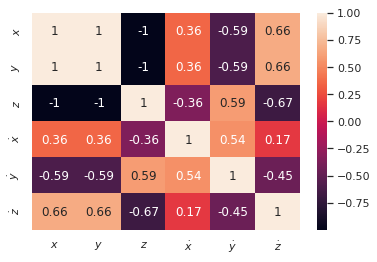

In [51]:
C = np.copy(o.covar_xyz)
d = np.diag(C)
coeffs = C / np.sqrt(np.outer(d, d))
el_keys = [r'$x$',r'$y$',r'$z$',r'$\dot{x}$',r'$\dot{y}$',r'$\dot{z}$']
sns.heatmap(coeffs, xticklabels=el_keys, yticklabels=el_keys,annot=True)
print(np.sqrt(d))

[5.85362675e-06 9.50166988e-03 4.98610885e-07 1.07640184e-04
 1.52245509e-03 1.50306343e-02]


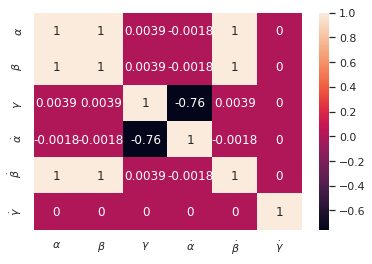

In [52]:
C = np.copy(o.covar_abg)
d = np.diag(C)
print(np.sqrt(d))
coeffs = C / np.sqrt(np.outer(d, d))
el_keys = [r'$\alpha$',r'$\beta$',r'$\gamma$',r'$\dot{\alpha}$',r'$\dot{\beta}$',r'$\dot{\gamma}$']
sns.heatmap(coeffs, xticklabels=el_keys, yticklabels=el_keys,annot=True)
#plt.title('2013 GU136 Correlation Coefficients')
#plt.savefig('Correlation_Coeffs.png')

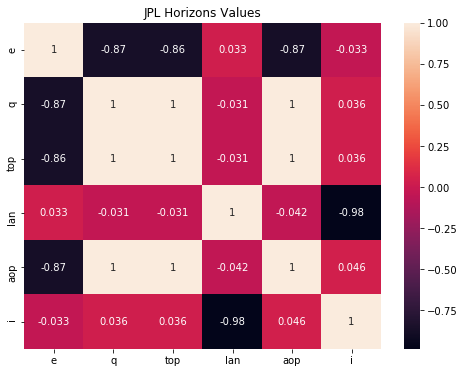

In [23]:
covar_2013_GU136 = [[5.676746972659048E-8,-1.449371917731691E-6,-.003282028496680913,6.888129511325739E-9,-1.761987392538002E-5,-3.895092260954857E-9],
    [-1.449371917731691E-6, 4.943781523915879E-5, .1122435365710287, -1.932979066475629E-7, .0005966025447536612, 1.269164759776378E-7],
    [-.003282028496680913, .1122435365710287,255.1655622708339,-.0004387657328545017,1.355890542358795,.0002879436860831808],
    [6.888129511325739E-9, -1.932979066475629E-7,-.0004387657328545017,7.651747850143278E-7,-3.102856947845479E-6,-4.320175018906224E-7],
    [-1.761987392538002E-5, .0005966025447536612,1.355890542358795,-3.102856947845479E-6,.007208012925995168,1.959682999345549E-6],
    [-3.895092260954857E-9, 1.269164759776378E-7,.0002879436860831808,-4.320175018906224E-7,1.959682999345549E-6,2.523235078769217E-7]]
axis_label = ['e','q','top','lan','aop','i']
C = np.array(covar_2013_GU136)
d = np.diag(C)
coeffs = C / np.sqrt(np.outer(d, d))
plt.figure(figsize=[8,6])
sns.heatmap(coeffs, xticklabels=axis_label, yticklabels=axis_label, annot=True)
plt.title('JPL Horizons Values')
plt.savefig('2013_GU136_coeffs.png')

In [24]:
pg_nums, ccd_nums, indexes = load_pg_nums('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/')

# for j in range(len(pg_nums)):
#     pg_num = pg_nums[j]
#     ccd_num = ccd_nums[j]
#     index = indexes[j]
#     fo_result = find_orbits_findorb(pg_num,ccd_num,index,gen_mpc_files=False)
    
orbit_dict = {}
orbit_dict_key = '{:03d}_{:02d}_{:04d}'
for i in tqdm(range(len(pg_nums))):
    pg_num = pg_nums[i]
    ccd_num = ccd_nums[i]
    index = indexes[i]
    orbit_dict[orbit_dict_key.format(pg_num,ccd_num,index)] = find_orbits_bernstein(pg_num,ccd_num,index,gen_mpc_files=False,return_covar=True)
    _ = find_orbits_findorb(pg_num, ccd_num, index, gen_mpc_files=False)

 79%|███████▉  | 82/104 [01:34<00:24,  1.11s/it]/epyc/users/brycek/kbmod/analysis/pyOrbfit/Orbit.py:190: RuntimeWarning: invalid value encountered in sqrt
  elements_errs['a'] = np.sqrt(self.covar_aei[0][0])
/epyc/users/brycek/kbmod/analysis/pyOrbfit/Orbit.py:192: RuntimeWarning: invalid value encountered in sqrt
  elements_errs['e'] = np.sqrt(self.covar_aei[1][1])
/epyc/users/brycek/kbmod/analysis/pyOrbfit/Orbit.py:194: RuntimeWarning: invalid value encountered in sqrt
  elements_errs['i'] = np.sqrt(self.covar_aei[2][2])/(np.pi/180)
/epyc/users/brycek/kbmod/analysis/pyOrbfit/Orbit.py:196: RuntimeWarning: invalid value encountered in sqrt
  elements_errs['lan'] = np.sqrt(self.covar_aei[3][3])/(np.pi/180)
100%|██████████| 104/104 [01:59<00:00,  1.15s/it]


7.671593617729995
41.27692519788145


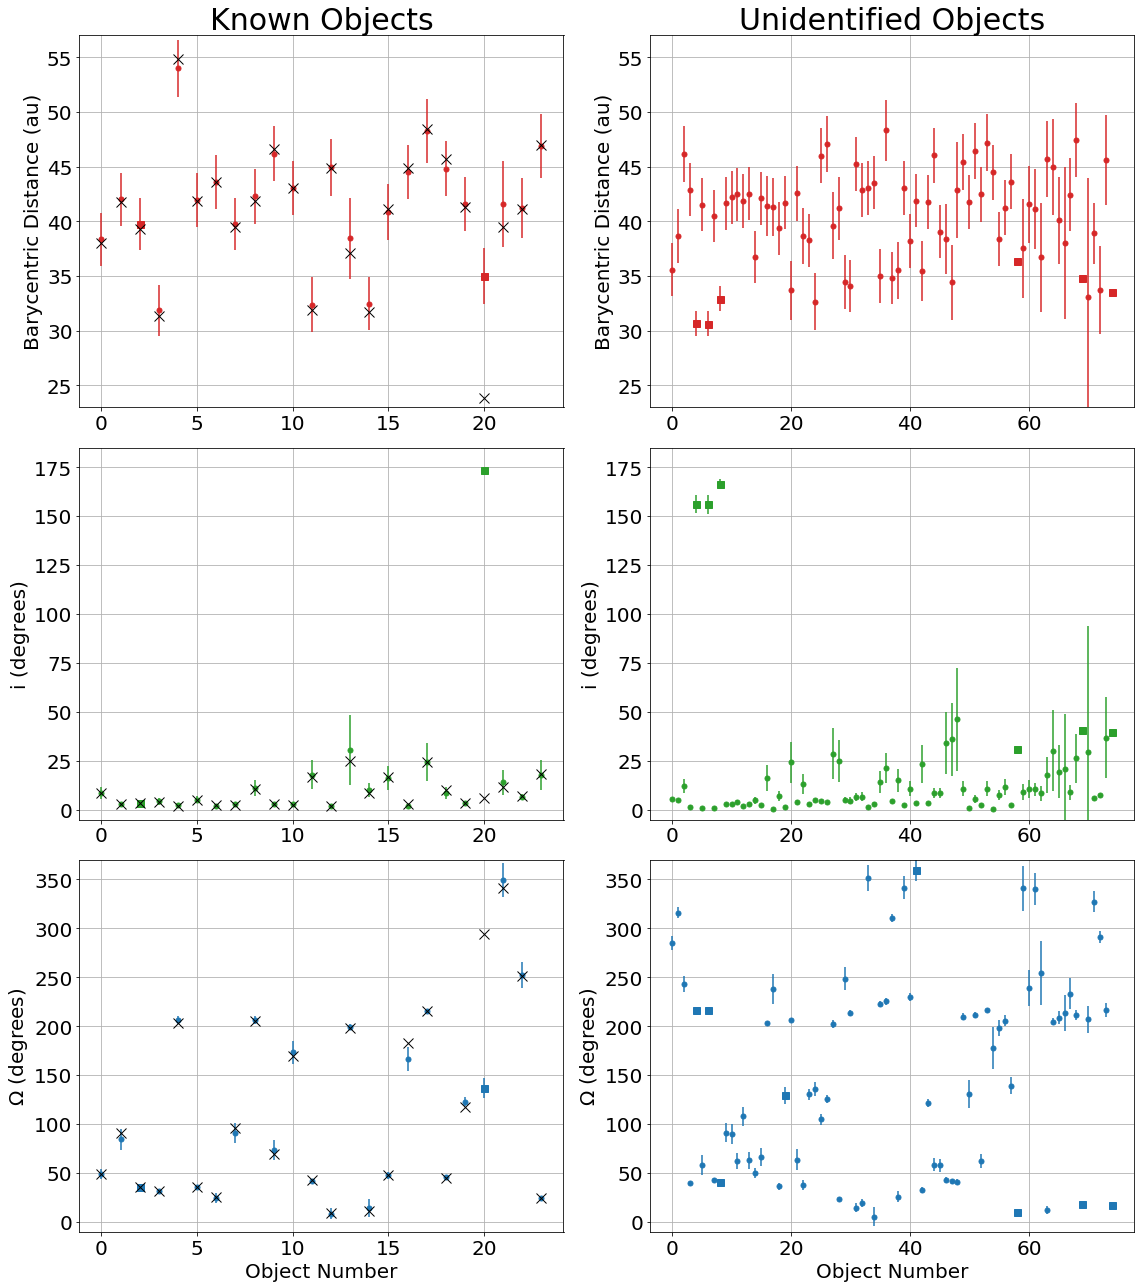

In [51]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=[16,18])

for ax0 in ax.reshape(-1):
    ax0.grid(True,zorder=-1)
    ax0.tick_params(labelsize=20)
pg_nums, ccd_nums, indexes = load_pg_nums('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/known_objects/kbmod_stamps')
bary_dist, bary_dist_err = get_ber_bary_dist(pg_nums, ccd_nums, indexes, orbit_dict)
a, a_err, e, e_err, i, i_err, lan, lan_err, aop, aop_err, top, top_err = parse_bernstein_results(pg_nums, ccd_nums, indexes, orbit_dict)
_,_,_,_, fo_i, fo_i_err, fo_lan, fo_lan_err, _,_,_,_ = parse_findorb_results(pg_nums, ccd_nums, indexes)

fo_bary = []
for j in range(len(pg_nums)):
    fo_bary.append(get_fo_bary_dist(pg_nums[j], ccd_nums[j], indexes[j]))
    
x = np.linspace(0,len(bary_dist)-1,len(bary_dist))

known_bary_dist = load_horizon_orbits(
    '/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/known_objects/kbmod_stamps',data_type='bary_dist')
_, _,known_i, known_lan,_,_ = load_horizon_orbits(
    '/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/known_objects/kbmod_stamps',data_type='orbital_elements')

bary_consistent = np.isclose(bary_dist, fo_bary,atol=bary_dist_err,rtol=0)
bary_inconsistent = np.logical_not(bary_consistent)
ax[0][0].set_title('Known Objects',fontsize=30)
ax[0][0].errorbar(x[bary_inconsistent],np.array(bary_dist)[bary_inconsistent],yerr=np.array(bary_dist_err)[bary_inconsistent],marker='s',ms=7,ls='',c='tab:red')
ax[0][0].errorbar(x[bary_consistent],np.array(bary_dist)[bary_consistent],yerr=np.array(bary_dist_err)[bary_consistent],marker='.',ms=10,ls='',c='tab:red')
ax[0][0].plot(x, known_bary_dist, marker='x',ls='',ms=10,c='k',zorder=3)
ax[0][0].set_ylim([23,57])

i_consistent = np.isclose(i,fo_i,atol=i_err,rtol=0)
i_inconsistent = np.logical_not(i_consistent)
ax[1][0].errorbar(x[i_inconsistent],np.array(i)[i_inconsistent],yerr=np.array(i_err)[i_inconsistent],marker='s',ms=7,ls='',c='tab:green')
ax[1][0].errorbar(x[i_consistent],np.array(i)[i_consistent],yerr=np.array(i_err)[i_consistent],marker='.',ms=10,ls='',c='tab:green')
ax[1][0].plot(x, known_i, marker='x',ls='',ms=10,c='k', zorder=3)
ax[1][0].set_ylim([-5,185])

lan_consistent = np.isclose(lan, fo_lan, atol=lan_err,rtol=0)
lan_inconsistent = np.logical_not(lan_consistent)
ax[2][0].errorbar(x[lan_inconsistent],np.array(lan)[lan_inconsistent],yerr=np.array(lan_err)[lan_inconsistent],marker='s',ms=7,ls='',c='tab:blue')
ax[2][0].errorbar(x[lan_consistent],np.array(lan)[lan_consistent],yerr=np.array(lan_err)[lan_consistent],marker='.',ms=10,ls='',c='tab:blue')
ax[2][0].plot(x, known_lan, marker='x',ls='',ms=10,c='k', zorder=3)
ax[2][0].set_ylim([-10,370])

ax[0][0].set_ylabel('Barycentric Distance (au)',fontsize=20)
ax[1][0].set_ylabel('i (degrees)',fontsize=20)
ax[2][0].set_ylabel('$\Omega$ (degrees)',fontsize=20)

pg_nums, ccd_nums, indexes = load_pg_nums('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/unidentified_objects')
bary_dist, bary_dist_err = get_ber_bary_dist(pg_nums, ccd_nums, indexes, orbit_dict)
a, a_err, e, e_err, i, i_err, lan, lan_err, aop, aop_err, top, top_err = parse_bernstein_results(pg_nums, ccd_nums, indexes, orbit_dict)
_,_,_,_, fo_i, fo_i_err, fo_lan, fo_lan_err, _,_,_,_ = parse_findorb_results(pg_nums, ccd_nums, indexes)
fo_bary = []
for j in range(len(pg_nums)):
    fo_bary.append(get_fo_bary_dist(pg_nums[j], ccd_nums[j], indexes[j]))

x = np.linspace(0,len(bary_dist)-1,len(bary_dist))

ax[0][1].set_title('Unidentified Objects',fontsize=30)

bary_consistent = np.isclose(bary_dist, fo_bary,atol=bary_dist_err,rtol=0)
bary_inconsistent = np.logical_not(bary_consistent)
ax[0][1].errorbar(x[bary_inconsistent],np.array(bary_dist)[bary_inconsistent],yerr=np.array(bary_dist_err)[bary_inconsistent],marker='s',ms=7,ls='',c='tab:red')
ax[0][1].errorbar(x[bary_consistent],np.array(bary_dist)[bary_consistent],yerr=np.array(bary_dist_err)[bary_consistent],marker='.',ms=10,ls='',c='tab:red')
ax[0][1].set_ylim([23,57])

i_consistent = np.isclose(i,fo_i,atol=i_err,rtol=0)
i_inconsistent = np.logical_not(i_consistent)
ax[1][1].errorbar(x[i_inconsistent],np.array(i)[i_inconsistent],yerr=np.array(i_err)[i_inconsistent],marker='s',ms=7,ls='',c='tab:green')
ax[1][1].errorbar(x[i_consistent],np.array(i)[i_consistent],yerr=np.array(i_err)[i_consistent],marker='.',ms=10,ls='',c='tab:green')
ax[1][1].set_ylim([-5,185])

lan_err = np.array(lan_err)
lan_err[np.isnan(lan_err)] = 0
lan_consistent = np.isclose(lan, fo_lan, atol=lan_err,rtol=0)
lan_inconsistent = np.logical_not(lan_consistent)
ax[2][1].errorbar(x[lan_inconsistent],np.array(lan)[lan_inconsistent],yerr=np.array(lan_err)[lan_inconsistent],marker='s',ms=7,ls='',c='tab:blue')
ax[2][1].errorbar(x[lan_consistent],np.array(lan)[lan_consistent],yerr=np.array(lan_err)[lan_consistent],marker='.',ms=10,ls='',c='tab:blue')
ax[2][1].set_ylim([-10,370])

ax[0][1].set_ylabel('Barycentric Distance (au)',fontsize=20)
ax[1][1].set_ylabel('i (degrees)',fontsize=20)
ax[2][1].set_ylabel('$\Omega$ (degrees)',fontsize=20)
print(np.median(i))
print(np.median(bary_dist))
ax[2][0].set_xlabel('Object Number',fontsize=20)
ax[2][1].set_xlabel('Object Number',fontsize=20)
plt.tight_layout()
#plt.savefig('OrbFit.pdf')

In [213]:
# Generate numbers discussed in the paper for the known objects.

pg_nums, ccd_nums, indexes = load_pg_nums('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/known_objects/kbmod_stamps')
bary_dist, bary_dist_err = get_ber_bary_dist(pg_nums, ccd_nums, indexes, orbit_dict)
a, a_err, e, e_err, i, i_err, lan, lan_err, aop, aop_err, top, top_err = parse_bernstein_results(pg_nums, ccd_nums, indexes, orbit_dict)
x = np.linspace(0,len(bary_dist)-1,len(bary_dist))

known_bary_dist = load_horizon_orbits(
    '/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/known_objects/kbmod_stamps',data_type='bary_dist')
_, _,known_i, known_lan,_,_ = load_horizon_orbits(
    '/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/known_objects/kbmod_stamps',data_type='orbital_elements')
print('====================================================================================')
print('KNOWN OBJECT STATS:')
print('====================================================================================')
# Show Horizon's median values
print('Median barycentric distance (Horizons):      {:.4f} au'.format(np.median(known_bary_dist)))
print('Median inclination (Horizons):               {:.4f} degrees'.format(np.median(known_i)))
# Show known object residuals
print('Median barycentric distance residual:        {:.4f} au'.format(np.median(np.abs(np.concatenate(known_bary_dist)-bary_dist))))
print('Median inclination residual:                 {:.4f} degrees'.format(np.median(np.abs(np.concatenate(known_i)-i))))
print('Median longitude of ascending node residual: {:.4f} degrees'.format(np.median(np.abs(np.concatenate(known_lan)-lan))))
print()
# Investigate known object 20: 2000 EE173
i = np.array(i)
print('Known object number {} is retrograde'.format(int(np.where(i>90)[0])))
print('PG: {} CCD: {} INDEX: {}'.format(pg_nums[20], ccd_nums[20], indexes[20]))
print('i = {:.2f} +/- {:.2f}'.format(i[i>90][0], np.array(i_err)[i>90][0]))
print('180-i = {:.2f}'.format(180-i[i>90][0]))
print('JPL Horizons value: i = {:.2f}'.format(np.concatenate(known_i)[i>90][0]))

KNOWN OBJECT STATS:
Median barycentric distance (Horizons):      41.5524 au
Median inclination (Horizons):               5.4614 degrees
Median barycentric distance residual:        0.3634 au
Median inclination residual:                 0.3177 degrees
Median longitude of ascending node residual: 0.9224 degrees

Known object number 20 is retrograde
PG: 284 CCD: 29 INDEX: 0
i = 173.36 +/- 0.54
180-i = 6.64
JPL Horizons value: i = 5.95


In [12]:
# Generate numbers for unidentified objects discussed in the paper

pg_nums, ccd_nums, indexes = load_pg_nums('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/unidentified_objects')
bary_dist, bary_dist_err = get_ber_bary_dist(pg_nums, ccd_nums, indexes, orbit_dict)
a, a_err, e, e_err, i, i_err, lan, lan_err, aop, aop_err, top, top_err = parse_bernstein_results(pg_nums, ccd_nums, indexes, orbit_dict)
print('====================================================================================')
print('UNIDENTIFIED OBJECT STATS:')
print('====================================================================================')

print('Unidentified object numbers ' + str(np.where(np.array(i)>90)[0]) + ' have i_fit>90')
print('Median barycentric distance: {:.4f} au'.format(np.median(bary_dist)))
print('Median inclination:          {:.4f} degrees'.format(np.median(i)))

UNIDENTIFIED OBJECT STATS:
Unidentified object numbers [4 6 8] have i_fit>90
Median barycentric distance: 41.2769 au
Median inclination:          7.6716 degrees


# Investigate 2000 EE173

In [9]:
# Investigate 2000 EE173

from pyOrbfit.Orbit import Orbit
from astroquery.mpc import MPC
from astroquery.jplhorizons import Horizons

#obs = MPC.get_observations('60608',get_mpcformat=True)
#obs.write('2000_EE173_mpc_obs.dat',format='csv',overwrite=True)
#obj = Horizons(id='2000 EE173')
#obj.elements()

o = Orbit(file='2000_EE173_mpc_obs-Copy1.dat')
#o = ep.predict_elements(file_in=input_file_name)

el = o.elements
err = o.elements_errs
covar = o.covar_aei
print(el)

{'a': -2.1828296232978035, 'e': 25.326396693216054, 'i': 6.129085790306155, 'lan': 294.4581813386638, 'aop': 224.13652765049466, 'top': nan}


In [11]:
import os
import json
os.environ['PATH'] = '~/bin:$PATH'

object_string = '2000_EE173_Extended_Orbit'
output_file_name = '2000_EE173_mpc_obs-Copy1.dat'
os.system('mkdir find_orb_results/{}'.format(object_string))
os.system('fo /epyc/users/smotherh/kbmod_epyc/notebooks/{} -O find_orb_results/{}'.format(output_file_name,object_string))
with open('/epyc/users/smotherh/kbmod_epyc/notebooks/find_orb_results/{}/total.json'.format(object_string,'r')) as f:
    fo_results = json.load(f)

In [13]:
fo_results['objects']['(60608)']

{'object': '(60608)',
 'packed': '60608',
 'created': 2459293.39419,
 'created iso': '2021-03-19T21:27:38Z',
 'elements': {'central body': 'Sun',
  'frame': 'J2000 ecliptic',
  'epoch_iso': '2015-04-22T00:00:00Z',
  'epoch': 2457134.5,
  'P': 128347.66130969032,
  'P sigma': 41.1,
  'M': 8.2259174909458,
  'M sigma': 0.0023,
  'n': 0.0028048816498,
  'n sigma': 8.99e-07,
  'a': 49.7958352956494,
  'a sigma': 0.0106,
  'e': 0.5463817745565,
  'e sigma': 8.95e-05,
  'q': 22.5882984412901,
  'q sigma': 0.00037,
  'Q': 77.0033721500088,
  'Q sigma': 0.0209,
  'i': 5.9493005412725,
  'i sigma': 3.6e-05,
  'arg_per': 235.6054632654258,
  'arg_per sigma': 0.0016,
  'asc_node': 293.9844037549236,
  'asc_node sigma': 0.00033,
  'Tp': 2454201.78535531,
  'Tp sigma': 0.152,
  'Tp_iso': '2007-04-11T06:50:54.698Z',
  'H': 8.59,
  'G': 0.15,
  'rms_residual': 0.28532,
  'weighted_rms_residual': 0.5706,
  'n_resids': 88,
  'U': 3.4412,
  'p_NEO': 0.0,
  'MOIDs': {'Mercury': 22.212759,
   'Venus': 21.

# Check Inclination Distribution

This repeats the analysis done in Widden et al. 2019

In [17]:
from scipy import interpolate
from astropy import coordinates
from astropy import units as u
import ephem
# Inclination distribution

def kbo_double_gaussian_population(i, norm_1, norm_2, a, sig_2, sig_3):
    
    f = np.sin(np.radians(i))*((a/norm_1)*np.exp(-i**2./(2*sig_2**2.)) + ((1.-a)/norm_2)*np.exp(-i**2./(2*sig_3**2.)))
    
    return f

# From Brown 2001
a = 0.83
sig_2 = 2.6
sig_3 = 15.0
# Brown's values are not from normalized Gaussians
norm_1 = 1.0
norm_2 = 1.0

# Generate a distribution as an array
xi = np.arange(0, 90., 0.001)
brown_dbl_gaussian_probs = []
for xi_a in xi:
    brown_dbl_gaussian_probs.append(kbo_double_gaussian_population(xi_a, norm_1, norm_2, a, sig_2, sig_3))

# Normalize
brown_dbl_gaussian_probs = np.array(brown_dbl_gaussian_probs)
brown_dbl_gaussian_probs /= np.sum(brown_dbl_gaussian_probs)*.001

# Create cumulative distribution
cum_dist = []
cum_dist.append(brown_dbl_gaussian_probs[0]*0.001)
for idx in range(1, len(brown_dbl_gaussian_probs)):
    cum_dist.append(cum_dist[idx-1] + brown_dbl_gaussian_probs[idx]*0.001)

# Interpolate
brown_dbl_gaussian_cum_dist = interpolate.interp1d(cum_dist, xi)

In [18]:
# Given random fraction between 0 and 1, what latitude do I assign for an object of inclination, i
# Use Eq. 1 from Brown (2001) and invert to solve for beta from f(beta)
# Randomly position along a circular orbit
def lat_from_frac(i):
    
    pi_vals = np.random.uniform(0, 2*np.pi, size=len(i))
    x = np.cos(pi_vals)*np.cos(np.radians(i))
    y = np.sin(pi_vals)
    z = -1.*np.cos(pi_vals)*np.sin(np.radians(i))
    lat = np.arctan2(z, np.sqrt(x**2. + y**2.))

    return np.degrees(lat), pi_vals

# Randomly draw from an inclination distribution already set above
def draw_inclinations(cum_dist, num_points):
    np.random.seed(460002)
    rand_draws = np.random.uniform(size=num_points)
    i_dist = []
    for i in range(num_points):
        new_i = cum_dist(rand_draws[i])
        i_dist.append(new_i)
        
    return np.array(i_dist)

def find_pn(lats, i_dist, object_inc, object_lat):
    
    keep_idx = np.where(np.abs(lats-object_lat) <= 0.5)
    keep_inc = i_dist[keep_idx]
    
    inc_below = np.where(keep_inc <= object_inc)[0]
    pn = len(inc_below)/len(keep_inc)
    
    return pn

def get_discovery_ecliptic(dir_path, filenames):

    disc_vals = []
    
    for filename in filenames:
        with open(os.path.join(dir_path, filename)) as f:
            for line in f:
                ra_hour = line[32:34]
                ra_min = line[35:37]
                ra_sec = line[38:44]
                dec_deg = line[44:47]
                dec_min = line[48:50]
                dec_sec = line[51:56]
                break

        coords = ["%s %s %s %s %s %s" % (ra_hour, ra_min, ra_sec, dec_deg, dec_min, dec_sec)]
        c = coordinates.SkyCoord(coords, frame="icrs", unit=(u.hourangle, u.deg))
        eq = ephem.Equatorial(ephem.hours(c.ra.rad), ephem.degrees(c.dec.rad))
        ec = ephem.Ecliptic(eq)
        disc_vals.append([np.degrees(ec.lon), np.degrees(ec.lat)])

    disc_props = np.array(disc_vals)
    disc_props = pd.DataFrame(disc_props, columns=['lon', 'lat'])
    
    return disc_props

In [25]:
# Load inclinations for the objects and check for consistency between find_orb and bernstein
pg_nums, ccd_nums, indexes = load_pg_nums('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/unidentified_objects/')
a, a_err, e, e_err, inc, inc_err, lan, lan_err, aop, aop_err, top, top_err = parse_bernstein_results(pg_nums, ccd_nums, indexes, orbit_dict)
_,_,_,_, fo_i, fo_i_err, _,_, _,_,_,_ = parse_findorb_results(pg_nums, ccd_nums, indexes)
i_consistent = np.isclose(inc,fo_i,atol=inc_err,rtol=0)
inc = np.array(inc)[i_consistent]
pg_nums = np.array(pg_nums)[i_consistent]
ccd_nums = np.array(ccd_nums)[i_consistent]
indexes = np.array(indexes)[i_consistent]

known_pg_nums, known_ccd_nums, known_indexes = load_pg_nums('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/known_objects/kbmod_stamps/')
a, a_err, e, e_err, known_inc, known_inc_err, lan, lan_err, aop, aop_err, top, top_err = parse_bernstein_results(known_pg_nums, known_ccd_nums, known_indexes, orbit_dict)
_,_,_,_, fo_i, fo_i_err, _,_, _,_,_,_ = parse_findorb_results(known_pg_nums, known_ccd_nums, known_indexes)
i_consistent = np.isclose(known_inc,fo_i,atol=known_inc_err,rtol=0)
known_inc = np.array(known_inc)[i_consistent]
known_pg_nums = np.array(known_pg_nums)[i_consistent]
known_ccd_nums = np.array(known_ccd_nums)[i_consistent]
known_indexes = np.array(known_indexes)[i_consistent]

inc = np.concatenate([inc,known_inc])
pg_nums = np.concatenate([pg_nums, known_pg_nums])
ccd_nums = np.concatenate([ccd_nums, known_ccd_nums])
indexes = np.concatenate([indexes, known_indexes])

# pg_nums = np.array(pg_nums)[inc<90]
# ccd_nums = np.array(ccd_nums)[inc<90]
# indexes = np.array(indexes)[inc<90]
# inc = inc[inc<90]

# Load mpc files for the objects
file_names = []
dir_path = '/epyc/users/smotherh/kbmod_epyc/notebooks/'
for i in range(len(pg_nums)):
    object_string = '{:03d}_{:02d}_{:04d}'.format(pg_nums[i],ccd_nums[i],indexes[i])
    file_names.append('{}_mpc.dat'.format(object_string))

# Get the ecliptic lat and lon for the unidentified objects
disc_properties = get_discovery_ecliptic(dir_path, file_names)

# Sample from the brown 2001 distribution
brown_dg_i_dist = draw_inclinations(brown_dbl_gaussian_cum_dist, 100000)

np.random.seed(592737)
brown_dg_v_vals = []
for i in tqdm(range(1000)):
    brown_dg_lats, brown_pi_vals = lat_from_frac(brown_dg_i_dist)
    brown_dg_pn = [find_pn(brown_dg_lats, brown_dg_i_dist, obj_inc, obj_disc_lat) for obj_inc, obj_disc_lat in zip(inc, disc_properties['lat'])]
    
    brown_dg_pn_sort = np.sort(brown_dg_pn)

    uniform_compare = np.linspace(0, 1, len(brown_dg_pn)+1)

    d_max = np.max(uniform_compare[1:] - brown_dg_pn_sort)
    d_min = np.max(brown_dg_pn_sort - uniform_compare[:-1])
    brown_dg_v = (d_max + d_min)*np.sqrt(len(brown_dg_pn))

    #print(brown_dg_v, np.where(ks_value[ks_sort] > brown_dg_v)[0][0], d_max, d_min)
    brown_dg_v_vals.append(brown_dg_v)

100%|██████████| 1000/1000 [00:53<00:00, 18.84it/s]


In [26]:
np.random.seed(418516)
ks_value = []
uniform_base = np.linspace(0, 1, len(inc)+1)
for i in tqdm(range(100000)):
    uniform_set = np.random.uniform(size=len(inc))
    uniform_sort = np.sort(uniform_set)
    d_max = np.max(uniform_base[1:] - uniform_sort)
    d_min = np.max(uniform_sort - uniform_base[:-1])
    v = (d_max + d_min)*np.sqrt(len(inc))
    ks_value.append(v)

ks_sort = np.argsort(ks_value)
ks_value = np.array(ks_value)

100%|██████████| 100000/100000 [00:03<00:00, 28257.08it/s]


In [46]:
null_hypothesis = np.where(ks_value[ks_sort] > np.mean(brown_dg_v_vals))[0][0]
print(np.mean(brown_dg_v_vals), np.std(brown_dg_v_vals), null_hypothesis)
print('We can reject the hypothesis that the data came from the distribution with: {:.2f}% confidence'.format(null_hypothesis/len(ks_value)*100))

1.4040526974547973 0.04557922929862513 76617
We can reject the hypothesis that the data came from the distribution with: 76.62% confidence


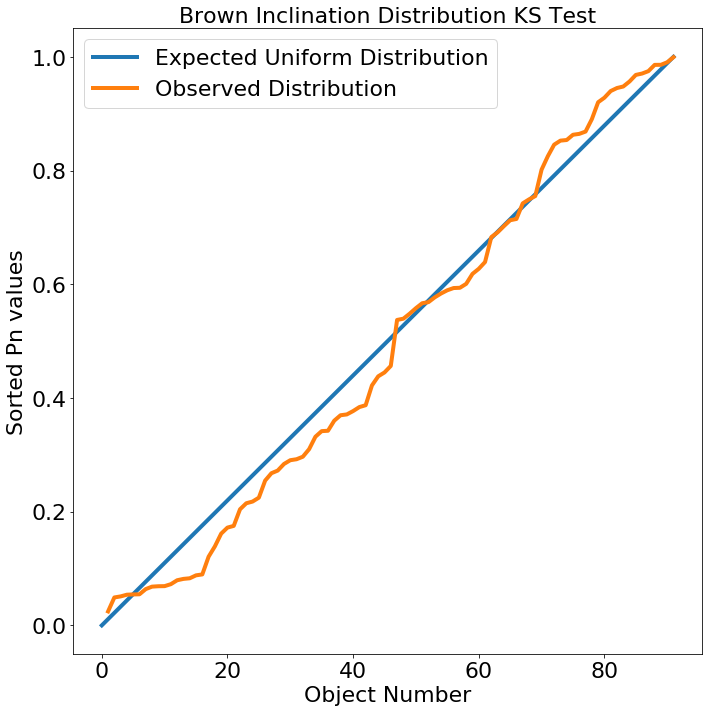

In [38]:
fig = plt.figure(figsize=(10,10))
plt.plot(np.arange(len(brown_dg_pn)+1), uniform_compare, lw=4, label='Expected Uniform Distribution', color='tab:blue')
plt.plot(np.arange(len(brown_dg_pn)+1)[1:], brown_dg_pn_sort, lw=4, label='Observed Distribution', c='tab:orange')
plt.xlabel('Object Number', size=22)
plt.ylabel('Sorted Pn values', size=22)
plt.xticks(size=22)
plt.yticks(size=22)
plt.legend(fontsize=22)
plt.title('Brown Inclination Distribution KS Test', size=22)
plt.tight_layout()
#plt.savefig('Brown_Inc_KS.pdf')

(array([ 5.,  3.,  8.,  7.,  8.,  9., 14., 18., 15.,  4.]),
 array([-7.91403157, -6.61493777, -5.31584397, -4.01675016, -2.71765636,
        -1.41856256, -0.11946875,  1.17962505,  2.47871885,  3.77781266,
         5.07690646]),
 <a list of 10 Patch objects>)

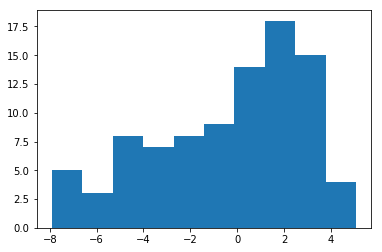

In [69]:
plt.hist(disc_properties['lat'])

(0, 60)

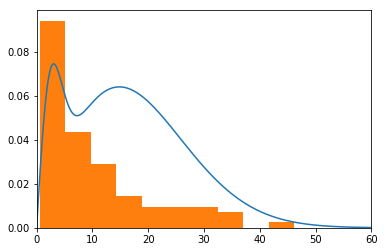

In [68]:
plt.plot(xi, np.array(brown_dbl_gaussian_probs)*1.8)
plt.hist(inc, density=True, bins='fd')
plt.xlim(0, 60)

In [40]:
# https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def angular_sep(lat1, lon1, lat2, lon2):

      dLat = np.radians(lat2 - lat1)
      dLon = np.radians(lon2 - lon1)
      lat1 = np.radians(lat1)
      lat2 = np.radians(lat2)

      a = np.sin(dLat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dLon/2)**2
      c = np.degrees(2*np.arcsin(np.sqrt(a)))

      return c


# Load the ecliptic lat and lon for the searched pointing groups
with open('/epyc/users/smotherh/LoriAllen/pointing_metadata/PickledPointingswSeeing.pkl', 'rb') as f:
    Pointing_Groups = pickle.load(f)
search_pg_nums = np.loadtxt('/epyc/users/smotherh/xsede_results/search_pg_list.txt',dtype=int)
pointing_lat = []
pointing_lon = []
for i in search_pg_nums:
    ra = Pointing_Groups[i]['ra'][0]
    dec = Pointing_Groups[i]['dec'][0]

    c = coordinates.SkyCoord(ra, dec, frame="icrs", unit=(u.deg, u.deg))
    eq = ephem.Equatorial(ephem.hours(c.ra.rad), ephem.degrees(c.dec.rad))
    ec = ephem.Ecliptic(eq)
    
    pointing_lat.append(np.degrees(ec.lat))
    pointing_lon.append(np.degrees(ec.lon))

np.random.seed(1859)
from scipy.spatial.distance import cdist
all_idx = np.array([])
single_idx = np.array([])
for f_lon, f_lat in zip(pointing_lon, pointing_lat):
    field_0 = []
    # Add in extra random uniform scatter to spread out the ascending nodes
    ang_sep = angular_sep(f_lat, f_lon, brown_dg_lats, np.degrees(brown_pi_vals)+np.random.uniform(0, 360., size=100000))
    #print(f_lat, f_lon)
    field_0 = np.where(ang_sep < 1.1)[0]
    all_idx = np.append(all_idx, field_0)
all_idx = np.array(all_idx, dtype=np.int)
#print(all_idx)

(array([ 5.,  3.,  8.,  7.,  8.,  9., 14., 18., 15.,  4.]),
 array([-7.91403157, -6.61493777, -5.31584397, -4.01675016, -2.71765636,
        -1.41856256, -0.11946875,  1.17962505,  2.47871885,  3.77781266,
         5.07690646]),
 <a list of 10 Patch objects>)

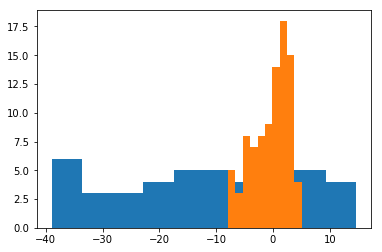

In [32]:
plt.hist(pointing_lat)
plt.hist(disc_properties['lat'])

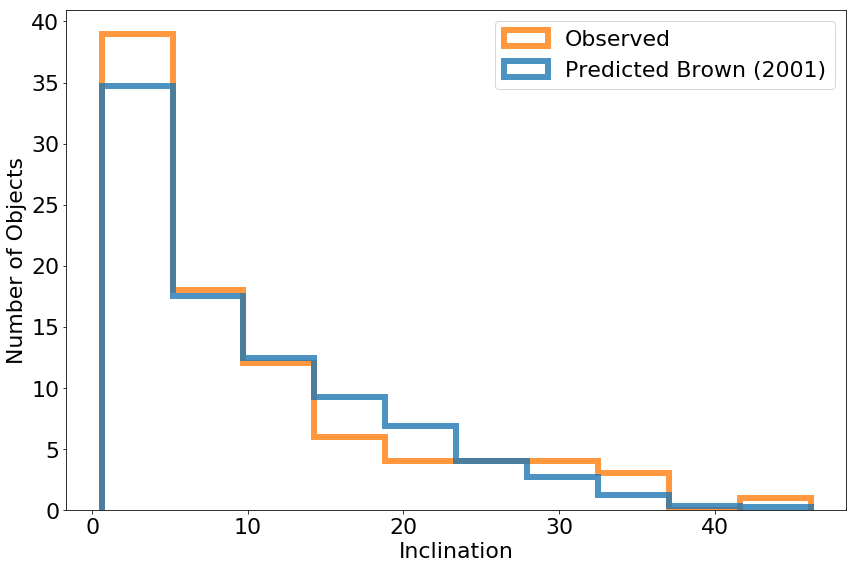

In [43]:
fig = plt.figure(figsize=(12,8))
n_2, bins, _ = plt.hist(np.array(inc), bins='fd', histtype='step', lw=6, label="Observed", color='tab:orange', alpha=0.8)
n_1, bins_1, _ = plt.hist(brown_dg_i_dist[all_idx], bins=bins, label="Predicted Brown (2001)", 
                      weights=np.ones(len(all_idx))*(len(inc)/len(all_idx)), histtype='step', lw=6, alpha=0.8, color='tab:blue')
#plt.hist(inc, bins=bins, histtype='step', lw=6, label="Observed", color='r')
plt.xticks(size=22)
plt.yticks(size=22)
plt.xlabel('Inclination', size=22)
plt.ylabel('Number of Objects', size=22)
plt.legend(fontsize=22)
plt.tight_layout()
#plt.savefig('Expected_Inc_Histogram.pdf')

In [45]:
from scipy.stats import chi2_contingency, chisquare
chisquare(n_2, f_exp=n_1)

Power_divergenceResult(statistic=8.582052502305466, pvalue=0.4767129734731691)

75


Text(0.5, 1.0, 'Unidentified Objects')

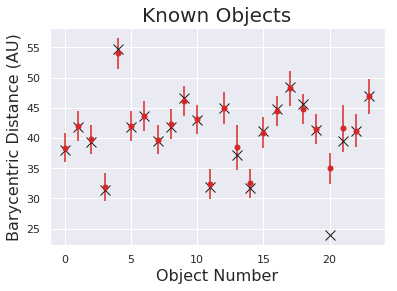

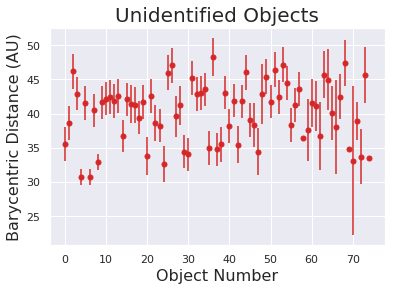

In [130]:
pg_nums, ccd_nums, indexes = load_pg_nums('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/known_objects/kbmod_stamps')
bary_dist, bary_dist_err = get_ber_bary_dist(pg_nums, ccd_nums, indexes, orbit_dict)
known_bary_dist = load_horizon_orbits('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/known_objects/kbmod_stamps',data_type='bary_dist')
x = np.linspace(0,len(bary_dist)-1,len(bary_dist))
plt.errorbar(x,bary_dist,yerr=bary_dist_err,marker='.',ms=10,ls='',c='tab:red')
plt.plot(x, known_bary_dist, marker='x',ls='',ms=10,c='k')
plt.xlabel('Object Number', fontsize=16)
plt.ylabel('Barycentric Distance (AU)',fontsize=16)
plt.title('Known Objects', fontsize=20)
#plt.savefig('known_object_bary_dist.png')

pg_nums, ccd_nums, indexes = load_pg_nums('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/unidentified_objects')
bary_dist, bary_dist_err = get_ber_bary_dist(pg_nums, ccd_nums, indexes, orbit_dict)
x = np.linspace(0,len(bary_dist)-1,len(bary_dist))
plt.figure()
plt.errorbar(x,bary_dist,yerr=bary_dist_err,marker='.',ms=10,ls='',c='tab:red')
plt.xlabel('Object Number', fontsize=16)
plt.ylabel('Barycentric Distance (AU)',fontsize=16)
plt.title('Unidentified Objects', fontsize=20)
#plt.savefig('known_object_bary_dist.png')

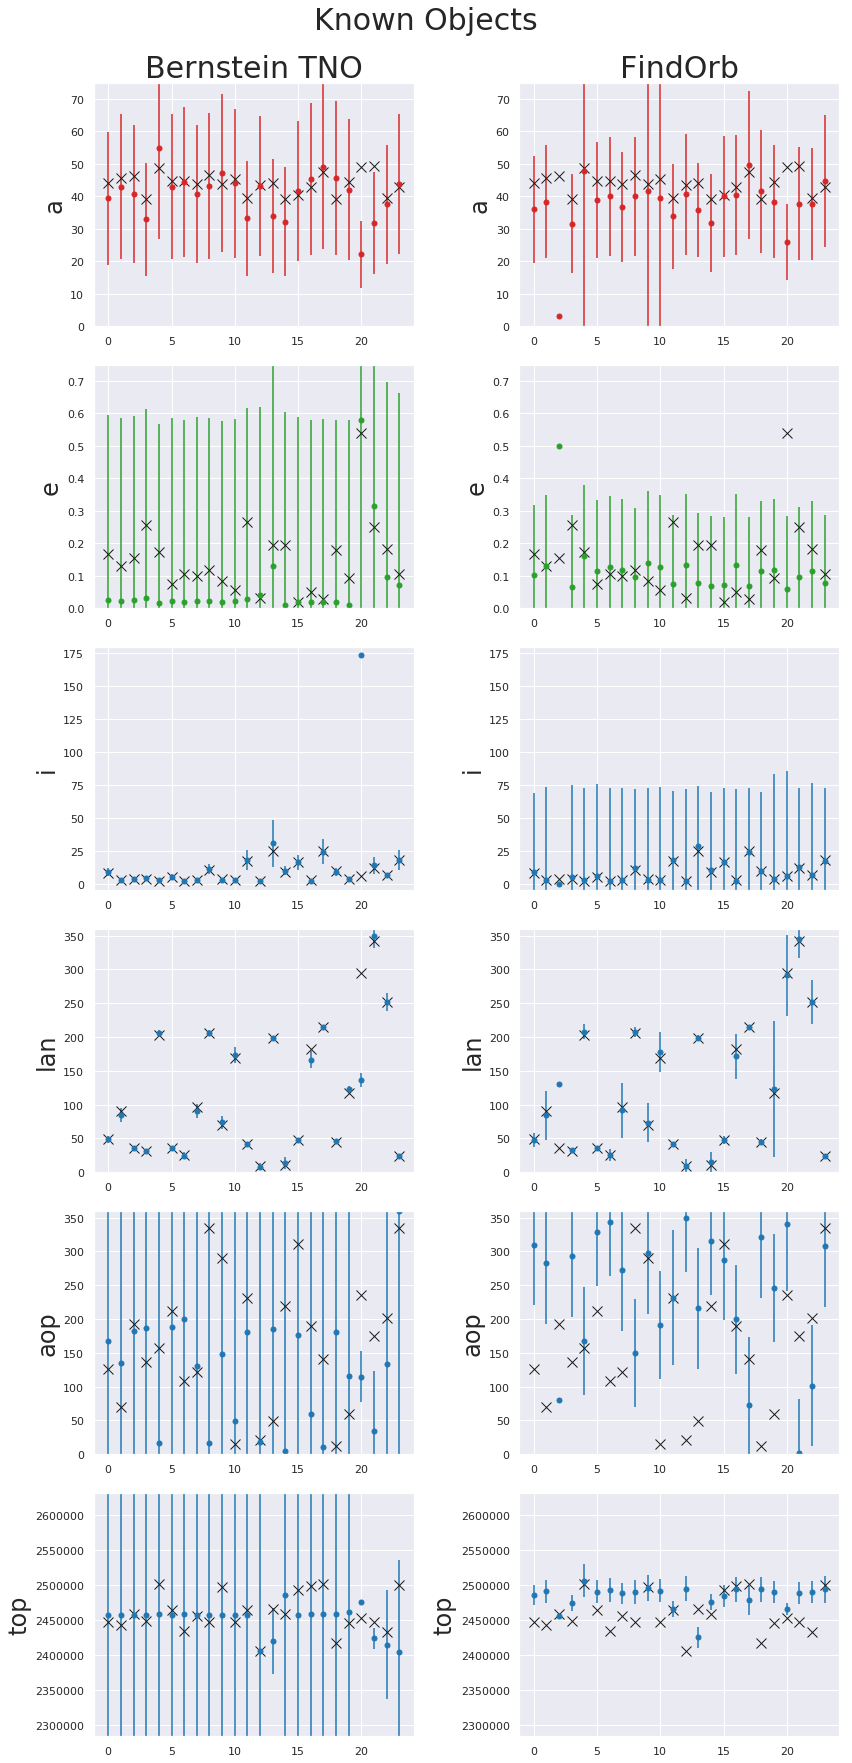

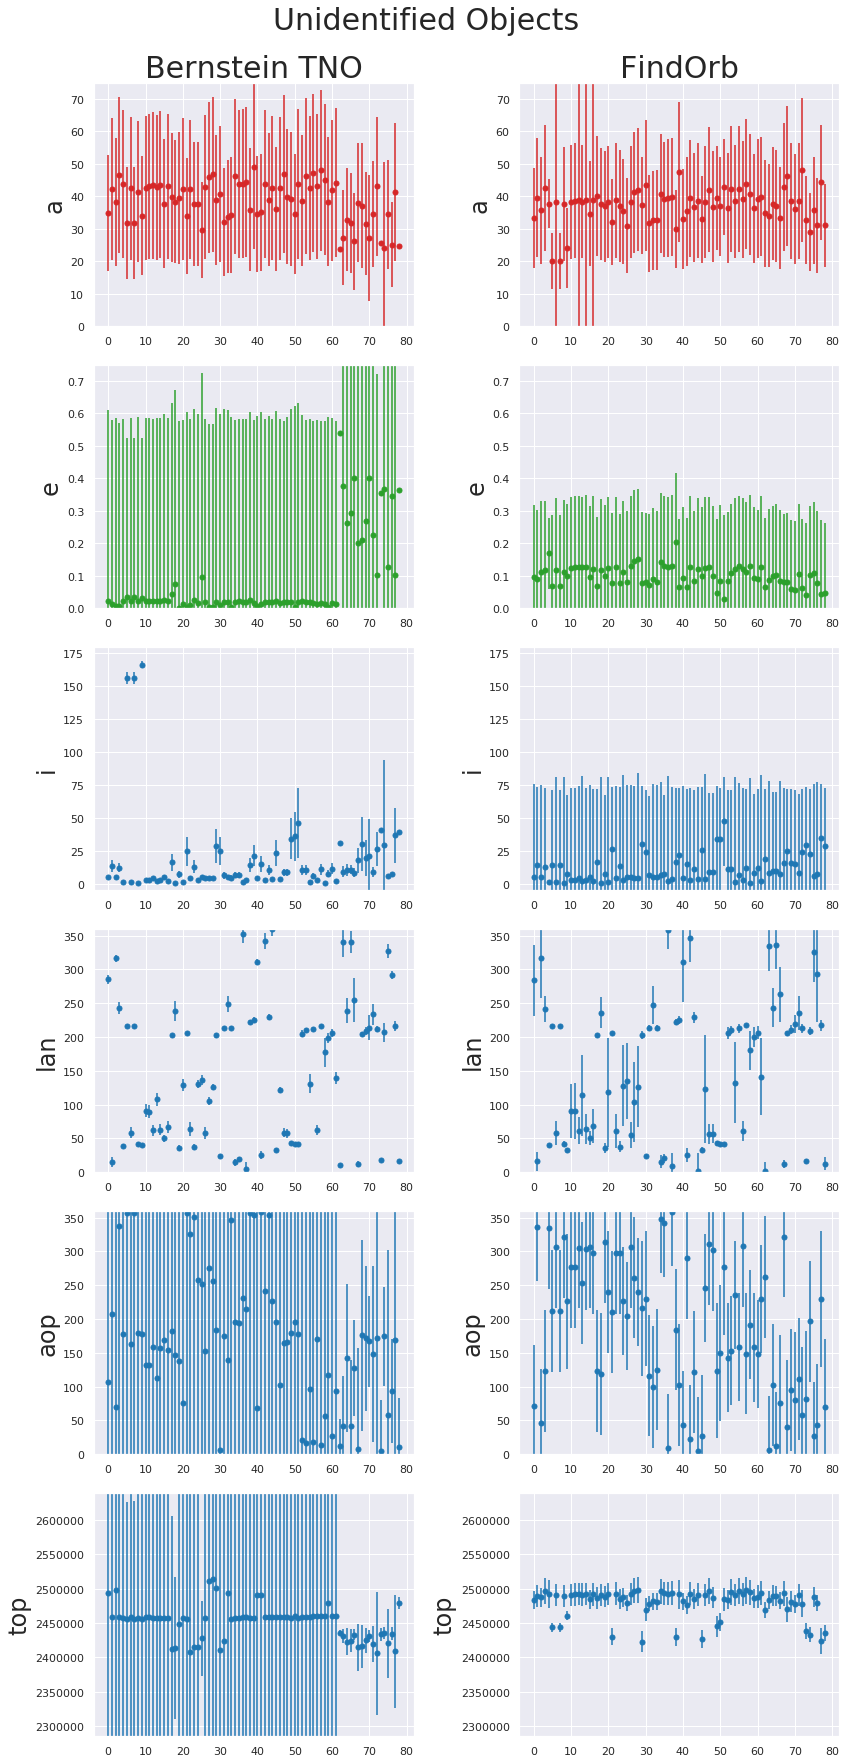

In [28]:
sns.set()
pg_nums, ccd_nums, indexes = load_pg_nums('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/known_objects/kbmod_stamps')
fo = parse_findorb_results(pg_nums, ccd_nums, indexes)
ber = parse_bernstein_results(pg_nums, ccd_nums, indexes, orbit_dict)
fig, ax = plot_fo_ber_comparison(fo, ber)

a, e, i, lan, aop, top = load_horizon_orbits('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/known_objects/kbmod_stamps')
ax[0][0].plot(a,marker='x',ms=10,ls='',color='k')
ax[0][1].plot(a,marker='x',ms=10,ls='',color='k')
ax[1][0].plot(e,marker='x',ms=10,ls='',color='k')
ax[1][1].plot(e,marker='x',ms=10,ls='',color='k')
ax[2][0].plot(i,marker='x',ms=10,ls='',color='k')
ax[2][1].plot(i,marker='x',ms=10,ls='',color='k')
ax[3][0].plot(lan,marker='x',ms=10,ls='',color='k')
ax[3][1].plot(lan,marker='x',ms=10,ls='',color='k')
ax[4][0].plot(aop,marker='x',ms=10,ls='',color='k')
ax[4][1].plot(aop,marker='x',ms=10,ls='',color='k')
ax[5][0].plot(top,marker='x',ms=10,ls='',color='k')
ax[5][1].plot(top,marker='x',ms=10,ls='',color='k')
fig.suptitle('Known Objects', y=1.02,fontsize=30)
plt.savefig('Known_Objects.png')

pg_nums, ccd_nums, indexes = load_pg_nums('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/unidentified_objects')
fo = parse_findorb_results(pg_nums, ccd_nums, indexes)
ber = parse_bernstein_results(pg_nums, ccd_nums, indexes, orbit_dict)
fig, ax = plot_fo_ber_comparison(fo, ber)
fig.suptitle('Unidentified Objects', y=1.02, fontsize=30)
plt.savefig('Unknown_Objects.png')


In [269]:
fig.savefig('BestFitOrbits.png')

The class loads the results file into a pandas dataframe called `results_df`.

## Predict location at other times

### Get coordinates of predictions

Now we can use the code to predict the location of the object at other times. Here we set a date range of 50 days before and after the initial observation in our **KBMOD** search. Then we predict the (ra, dec) for these times before storing them in a pandas dataframe with the time of each predicted location.

In [46]:
date_range = np.arange(ep.mjd_0-50., ep.mjd_0+50., 0.5)
pred_ra, pred_dec = ep.predict_ephemeris(date_range, file_in=None)

# Take this data and turn into a pandas dataframe of predicted observational locations and times
ephem_df = pd.DataFrame(np.array([date_range, pred_ra, pred_dec]).T, columns=['mjd', 'pred_ra', 'pred_dec'])
ephem_df.head()

,mjd,pred_ra,pred_dec
0,56720.213255,216.808722,-11.966674
1,56720.713255,216.803955,-11.964729
2,56721.213255,216.799261,-11.962787
3,56721.713255,216.794326,-11.960792
4,56722.213255,216.789461,-11.958800


### Plot predicted locations

We can also take this data range and plot it with the observations from our search highlighted on the orbit.

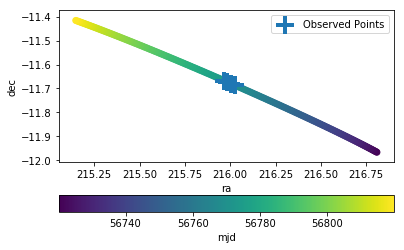

In [47]:
fig = ep.plot_predictions(date_range)

### Get predicted pixel locations in a new image

Take a new image and calculate the predicted pixel locations at given times for the object. Even though we use a single WCS it is useful to get an idea of where an object might be in a sequence of images taken of the same field.

In [48]:
new_image = str('/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/'+
                'Pointing_Group_300/processed_data/rerun/rerun_processed_data/0434610/'+
                'calexp/calexp-0434610_22.fits')

new_times = np.arange(ep.mjd_0+1, ep.mjd_0+1.5, 0.1)

x_pix, y_pix = ep.predict_pixels(new_image, new_times)

# Create a pandas dataframe with the predicted x, y locations
pixel_df = pd.DataFrame(np.array([new_times, x_pix, y_pix]).T, columns=['mjd', 'pred_x_loc', 'pred_y_loc'])
pixel_df.head()

NoConvergence: 'WCS.all_world2pix' failed to converge to the requested accuracy.
After 2 iterations, the solution is diverging at least for one input point.